In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import timeit
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import scipy.stats as st
import math
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import cross_validate

## Data import and initial analysis

In [2]:
heart = pd.read_csv('heart.csv')

In [3]:
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


#### Shape of data

In [4]:
heart.shape

(918, 12)

#### Checking missing values

In [5]:
heart.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

#### Checking class imbalance (%)

In [6]:
round(heart['HeartDisease'].value_counts()/heart.shape[0]*100,2)

1    55.34
0    44.66
Name: HeartDisease, dtype: float64

In [7]:
X = heart.drop('HeartDisease',axis = 1)
y = heart['HeartDisease'].copy()

## Train-test-split, label encoding and normalisation

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#### Label encoding

In [9]:
columns_to_transform = X.select_dtypes(include = 'object').columns
le = preprocessing.LabelEncoder()
for col in columns_to_transform:
    le.fit(X_train[col])
    X_train[col] = le.transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

In [10]:
X_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
155,56,1,0,155,342,1,1,150,1,3.0,1
362,56,1,2,155,0,0,2,99,0,0.0,1
869,59,1,2,150,212,1,1,157,0,1.6,2
101,51,1,0,130,179,0,1,100,0,0.0,2
199,57,0,3,130,308,0,1,98,0,1.0,1


#### Data normalisation

In [11]:
for col in X_train.columns:
    scaler = MinMaxScaler()
    scaler.fit(X_train[col].to_numpy().reshape(-1,1))
    X_train[col] = scaler.transform(X_train[col].to_numpy().reshape(-1,1))
    X_test[col] = scaler.transform(X_test[col].to_numpy().reshape(-1,1))

In [12]:
X_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
155,0.562500,1.0,0.000000,0.775,0.567164,1.0,0.5,0.674419,1.0,0.636364,0.5
362,0.562500,1.0,0.666667,0.775,0.000000,0.0,1.0,0.279070,0.0,0.295455,0.5
869,0.625000,1.0,0.666667,0.750,0.351575,1.0,0.5,0.728682,0.0,0.477273,1.0
101,0.458333,1.0,0.000000,0.650,0.296849,0.0,0.5,0.286822,0.0,0.295455,1.0
199,0.583333,0.0,1.000000,0.650,0.510779,0.0,0.5,0.271318,0.0,0.409091,0.5


## Upsampling underrepresented class 0

In [13]:
train_full = X_train.join(y_train)

class0 = train_full[train_full['HeartDisease'] == 0]
class1 = train_full[train_full['HeartDisease'] == 1]

from sklearn.utils import resample
class0_upsample = resample(class0,
             replace=True,
             n_samples=len(class1),
             random_state=42)

train_full_upsampled = pd.concat([class1, class0_upsample])
X_train_upsampled = train_full_upsampled.iloc[:,:11]
y_train_upsampled = train_full_upsampled['HeartDisease']

In [14]:
print('Original number of class 0 samples:', class0.shape[0])
print('Original number of class 1 samples:', class1.shape[0])
print('Number of upsampled class 0 samples:', class0_upsample.shape[0])

Original number of class 0 samples: 312
Original number of class 1 samples: 376
Number of upsampled class 0 samples: 376


## Gradient boosting default model

In [15]:
gb = GradientBoostingClassifier(random_state=42).fit(X_train_upsampled, y_train_upsampled)
print('Default model test accuracy: {:.4f}'.format(gb.score(X_test, y_test)))
print('Default model test recall: {:.4f}'.format(recall_score(y_test, gb.predict(X_test))) )


Default model test accuracy: 0.8957
Default model test recall: 0.8939


## Gradient boosting parameter tuning

In [16]:
learning_rate = [0.001,0.01,0.1,1]
max_depth =[None, 2,3,4]
n_estimators = range(80,160,20)
loss = ['log_loss','exponential']
criterion = ['friedman_mse', 'squared_error']
subsample = [1, 0.98,0.95]
max_leaf_nodes = [None, 6, 8, 10]

grid = {'learning_rate':learning_rate,
       'max_depth':max_depth,
       'n_estimators':n_estimators,
       'loss':loss,
       'criterion':criterion,
       'subsample':subsample,
       'max_leaf_nodes':max_leaf_nodes}

gb_search = GridSearchCV(GradientBoostingClassifier(random_state = 42), 
                         param_grid=grid, 
                         cv = 5,
                         scoring = 'recall',
                        n_jobs = -1)


start = timeit.default_timer()

gb_search.fit(X_train_upsampled, y_train_upsampled)

stop = timeit.default_timer()

print('GB parameter tuning in seconds: ', stop - start) 



GB parameter tuning in seconds:  473.696264528


In [17]:
print('Gradient boosting best parameters:' ,gb_search.best_params_)

print('\nBest model validation recall: {:.4f}'.format(gb_search.best_score_))

Gradient boosting best parameters: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': None, 'max_leaf_nodes': 8, 'n_estimators': 80, 'subsample': 0.95}

Best model validation recall: 0.9123


In [18]:
gb_df = pd.DataFrame(gb_search.cv_results_)[['mean_fit_time','params','mean_test_score','std_test_score','rank_test_score']]
gb_df.head()

,mean_fit_time,params,mean_test_score,std_test_score,rank_test_score
0,0.444488,"{'criterion': 'friedman_mse', 'learning_rate':...",0.827053,0.029572,3042
1,0.633530,"{'criterion': 'friedman_mse', 'learning_rate':...",0.837649,0.055158,2981
2,0.825150,"{'criterion': 'friedman_mse', 'learning_rate':...",0.853719,0.055942,2803
3,0.605041,"{'criterion': 'friedman_mse', 'learning_rate':...",0.824386,0.033442,3048
4,0.964213,"{'criterion': 'friedman_mse', 'learning_rate':...",0.840316,0.050849,2961


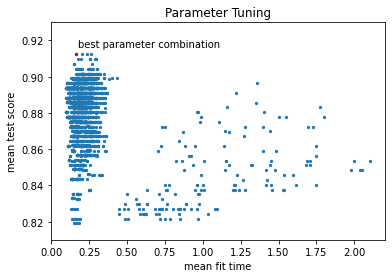

In [19]:
plt.figure()
plt.scatter(gb_df['mean_fit_time'],gb_df['mean_test_score'], s = 5)
best_para = gb_df[gb_df['params'] == gb_search.best_params_]
plt.scatter(best_para['mean_fit_time'], best_para['mean_test_score'], color="red", s = 5)
plt.annotate('best parameter combination', (best_para['mean_fit_time']+0.015, best_para['mean_test_score']+0.004))
plt.ylim(0.81,0.93)
plt.title('Parameter Tuning')
plt.xlabel('mean fit time')
plt.ylabel('mean test score')
plt.savefig('pt.png')

## Interpreting best GB model

In [20]:
importance_table = pd.DataFrame({'Features':X.columns,'Feature Importance':gb_search.best_estimator_.feature_importances_})
importance_table = importance_table.sort_values(by = 'Feature Importance')
importance_table

,Features,Feature Importance
6,RestingECG,0.007529
5,FastingBS,0.023356
1,Sex,0.042165
8,ExerciseAngina,0.043316
0,Age,0.052764
3,RestingBP,0.054339
2,ChestPainType,0.066109
7,MaxHR,0.067409
4,Cholesterol,0.085565
9,Oldpeak,0.100964


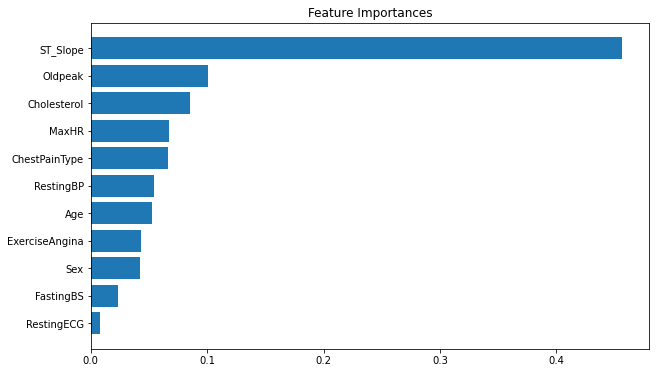

In [21]:
plt.figure(figsize = (10,6))
plt.barh(y = importance_table['Features'], width = importance_table['Feature Importance'])
plt.title('Feature Importances')
plt.savefig('fi.jpg')

## Overfitting

In [22]:
gb_best = gb_search.best_estimator_
print(gb_best)

GradientBoostingClassifier(max_depth=None, max_leaf_nodes=8, n_estimators=80,
                           random_state=42, subsample=0.95)


In [23]:
# generating accuracy and recall scores on train data with cross validation
gb_best_val_scores = cross_validate(gb_best, X_train_upsampled, y_train_upsampled, 
                                    scoring=('recall','accuracy'), cv=5, 
                                    return_train_score = True)
gb_best_val_scores

gb_val_recall = gb_best_val_scores['test_recall']
gb_train_recall = gb_best_val_scores['train_recall']

gb_val_acc = gb_best_val_scores['test_accuracy']
gb_train_acc = gb_best_val_scores['train_accuracy']

In [24]:
# conducting ttests 

print('Reject null hypothesis that the mean of validation and train recall are the same?')
print(st.ttest_ind(gb_val_recall, gb_train_recall, equal_var = False)[1] < 0.05)

print('\nReject null hypothesis that the mean of validation and train accuracy are the same?')
print(st.ttest_ind(gb_val_acc, gb_train_acc, equal_var = False)[1] < 0.05)

Reject null hypothesis that the mean of validation and train recall are the same?
True

Reject null hypothesis that the mean of validation and train accuracy are the same?
True


In [25]:
#plotting overfitting
n_trees = range(1, 160)
train_acc = []
val_acc = []
train_recall = []
val_recall = []

for n in n_trees:
    model = GradientBoostingClassifier(max_depth=None, max_leaf_nodes=8, n_estimators=n,
                           random_state=42, subsample=0.95)
    scores = cross_validate(model, X_train_upsampled, y_train_upsampled, scoring=('recall','accuracy'), 
                             cv=5,return_train_score= True)
    train_acc.append(np.mean(scores['train_accuracy']))
    train_recall.append(np.mean(scores['train_recall']))
    val_acc.append(np.mean(scores['test_accuracy']))
    val_recall.append(np.mean(scores['test_recall']))

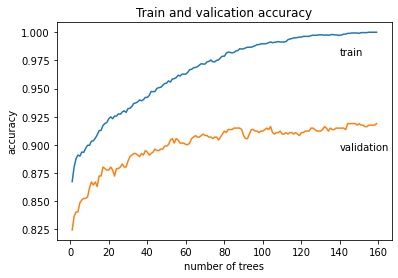

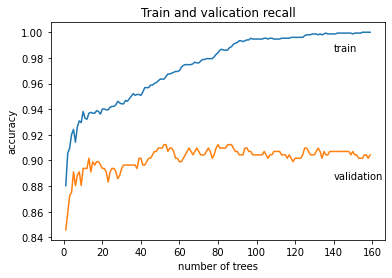

In [26]:
plt.figure()
plt.plot(n_trees, train_acc)
plt.plot(n_trees, val_acc)
plt.title('Train and valication accuracy')
plt.xlabel('number of trees')
plt.ylabel('accuracy')
plt.annotate('train',(140,0.980))
plt.annotate('validation',(140,0.895))
plt.savefig('acc.png')

plt.figure()
plt.plot(n_trees, train_recall)
plt.plot(n_trees, val_recall)
plt.title('Train and valication recall')
plt.xlabel('number of trees')
plt.ylabel('accuracy')
plt.annotate('train',(140,0.985))
plt.annotate('validation',(140,0.885))
plt.savefig('recall.png')

## Performance evaluation

In [27]:
gb_best = gb_search.best_estimator_
gb_best.fit(X_train_upsampled, y_train_upsampled)
gb_pred = gb_best.predict(X_test)

gb_accuracy = accuracy_score(y_test, gb_pred)
gb_f1 = f1_score(y_test, gb_pred)
gb_precision = precision_score(y_test, gb_pred)
gb_recall = recall_score(y_test, gb_pred)

gb_cm = confusion_matrix(y_test, gb_pred)

In [28]:
result = pd.DataFrame([gb_accuracy, gb_f1,gb_precision, gb_recall], 
                      index = ['Accuracy','F1','precision','recall'],
                      columns = ['Gradient Boosting'])
result['Gradient Boosting'] = round(result['Gradient Boosting'], 4)
result

,Gradient Boosting
Accuracy,0.8870
F1,0.9015
precision,0.9015
recall,0.9015


In [29]:
print('By class performance\n', classification_report(y_test, gb_pred, digits = 4))

By class performance
               precision    recall  f1-score   support

           0     0.8673    0.8673    0.8673        98
           1     0.9015    0.9015    0.9015       132

    accuracy                         0.8870       230
   macro avg     0.8844    0.8844    0.8844       230
weighted avg     0.8870    0.8870    0.8870       230



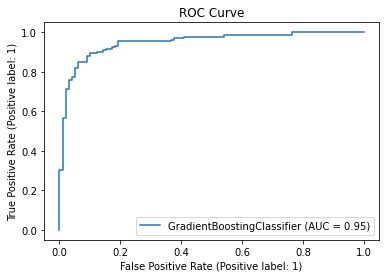

In [30]:
metrics.RocCurveDisplay.from_estimator(gb_best, X_test, y_test)
plt.title('ROC Curve')
plt.savefig('roc.jpg')

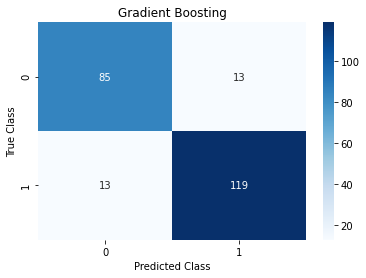

In [31]:
fig, ax = plt.subplots()

sns.heatmap(gb_cm, annot=True, cmap='Blues', fmt = 'g', ax = ax)
ax.set_title('Gradient Boosting')
ax.set_ylabel('True Class')
ax.set_xlabel('Predicted Class')
plt.savefig('cm.jpg')